# Introduction

This jupyter notebook file shows how I use neural networks to predict a boolean outcome variable. In short, this file follows these steps:

1. Getting the data from the SQL database
2. Creating submmision (a dataset where I need to make predictions), train, validation and test set
3. Cleaning the data and preparing for ML
4. Training a deep neural network and evaluating the accuracy
5. Making predictions for the unknown customer ID's

### Background of the dataset and case
Toy Storey sells toys online and offers shipping or pick-up globally. They have acquired third party credit card data of all online purchases of all merchants in the toy industry in one representative country. Note that different merchants handle data differently, and thus some data are only available for some merchants. Moreover, the customer_id can be linked to more than one individual.

*Here my task is to lassify which customers are exclusive ToyStorey-customers. For 10% of ToyStoreys customers in the third party data, the exlusivity is unknown. I will attempt to predict whether the customers are exclusive or not.*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlalchemy

# set standard figure size to bigger:
plt.rcParams['figure.figsize'] = [15, 10]

## 1) Get data from the database

In [2]:
# The string that sqlalchemy takes: mysql+pymysql:// + username: + password: + host: + port/ + database
engine = sqlalchemy.create_engine('mysql+pymysql://__________+____________+_____+_____/+__________')
# I removed the database information due to the file being public and wanting to prevent unwanted q

From the SQL database related to the customers that have credit card data I am interested in these variables:

- **exclusivity** (boolean) - whether the customer only buys from Toy Storey or not (1/0), also contains null values where it is unknown and I need to make predictions

- **total_amount** (float) - total amount a customer has spent
- **total_orders** (int) - total orders a customer has made
- **birth_year** (int) - the birth year of the customer
- **gender** (boolean) - customer's gender
- **distinct_devices** - number of different devices (max 3) the customer has used to purchase
- **spend_per_order** - total amount spent divided by total orders

In [3]:
# Count nulls
query_count = '''
SELECT sum(case when exclusive is null then 1 else 0 end) count_nulls
	, count(exclusive) count_not_nulls
FROM Exclusive
'''

query = '''
SELECT customer_id, SUM(amount) AS total_amount, COUNT(*) AS total_orders, birth_year, gender, 
NULLIF(COUNT(DISTINCT(device)), 0) AS distinct_devices, 
SUM(amount)/COUNT(*) AS spend_per_order, exclusive
FROM CreditCardData ccd
LEFT JOIN Exclusive e2 USING (customer_id)
WHERE customer_id IN 
(
	SELECT customer_id
	FROM Exclusive
)
GROUP BY customer_id 
'''

In [4]:
df = pd.read_sql_query(query, engine)

### 1.1) Fitting missing values to the median of the dataset:

In [5]:
# The distinct devices columns has some missing values, I will use the mode of the whole
# dataset to replace these NaN values with the most frequent values:
print('Distinct devices NaN will be replaced with:', df.distinct_devices.mode()[0])
df.distinct_devices = df.distinct_devices.fillna(value = df.distinct_devices.mode()[0]).astype('int8')

# The missing (NaN) values from the birth_year column will be changed to median birth_year:
median = df['birth_year'].median()
print('The median birth_year that replaces NaN is the following:', median)
df['birth_year'].fillna(median, inplace = True)

# I will change the gender from male/female into 1/0 binary:
df.gender = df.gender.eq('male').mul(1).astype('uint8')

Distinct devices NaN will be replaced with: 1.0
The median birth_year that replaces NaN is the following: 1977.0


In [ ]:
#df.to_csv('credit_card_dataset.csv', index = True)

In [ ]:
#df = pd.read_csv('credit_card_dataset.csv', index_col = 0)

## 2) Create submmision, train, validation and test set

In [6]:
data = pd.read_csv('Customer_ids.txt', sep=" ", header=None)
data.columns = ['customer_id']

In [7]:
# Create a submit dataframe where I separate the customer_id where the exclusivity
# is unknown and I need to predict it:
df_submit = pd.merge(data, df, how = 'inner', on = ['customer_id'])

# Now remove all NaN from the main dataframe:
df = df.dropna(subset = ['exclusive'])

# Drop also customer_id:
df = df.drop('customer_id', axis = 1)

In [16]:
from sklearn.model_selection import train_test_split

# Separate the target variable from the main table:
df_y = df["exclusive"].copy().astype(int)
df_X = df.drop("exclusive", axis = 1)

# Create a train, validation, and test sets:
X_full, X_test, y_full, y_test = train_test_split(df_X, df_y, test_size = 0.15, random_state = 42)

## 3) Clean the data and prepare for ML

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [10]:
corr_matrix = df.corr()
corr_matrix['exclusive'].sort_values(ascending = False)

exclusive           1.000000
gender              0.221829
birth_year         -0.026154
spend_per_order    -0.116533
distinct_devices   -0.355883
total_amount       -0.414143
total_orders       -0.591217
Name: exclusive, dtype: float64

In [17]:
# Create a pipeline for manipulating categorical variable (distinct_devices) into OHE,
# and scale the numerical variables:

cat_attribs = ['distinct_devices']
num_attribs = ['total_amount', 'total_orders', 'birth_year', 'spend_per_order']
binary_attribs = ['gender']

full_pipeline = ColumnTransformer([
    ('num', StandardScaler(), num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)], 
    remainder='passthrough'
)

X_full_prep = full_pipeline.fit_transform(X_full)
X_test_prep = full_pipeline.fit_transform(X_test)
print(X_full_prep.shape)
print(X_test_prep.shape)

(11683, 8)
(2062, 8)


These are my **explanatory variables**:
1. Total amount - total amount a customer has spent
2. Total orders - total orders a customer has made
3. Birth year - the birth year of the customer
4. Spend per order - total amount divided by total orders
5. Distinct devices - number of different devices (max 3) the customer has used to purchase
    * OHE, 3 variables in total
6. Gender - customer's gender

This is my **target variable**:
* Exclusive - whether the customer only buys from Toy Storey or not

## 4) Training a deep neural network and evaluating the accuracy

### Using LeCun initialization with self normalizing weights

In [12]:
import tensorflow as tf
from tensorflow import keras
import os

In [18]:
# Create a model
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()

# I am using 20 hidden layers, each hidden layer uses scaled ELU activation
# and the weights in layers are initialized using LeCun initialization, each layer
# has 100 neurons
for layer in range(20): 
    model.add(keras.layers.Dense(100, activation = 'selu', kernel_initializer="lecun_normal"))

# Last layer uses the sigmoid activation to get a probability output
model.add(keras.layers.Dense(1, activation="sigmoid"))

# Learning rate optimizer Nadam with a learning rate of 0.0005
optimizer = keras.optimizers.Nadam(lr = 5e-4)

model.compile(loss = keras.losses.BinaryCrossentropy(),
             optimizer = optimizer,
             metrics = ['accuracy'])

# Use early stopping as regularization to find the best model,
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 20)
# Save the model, but don't overwrite the best one!
checkpoint_cb = keras.callbacks.ModelCheckpoint('my_final_project_model.h5', save_best_only = True)

# Create a tensorboad directory to plot learning:
run_index = 10 # change index for runs!
run_logdir = os.path.join(os.curdir, 'my_final_project_logs', 'run_{:03d}_lecun'.format(run_index))

# Tensorboard callback:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

# Combine the callbacks:
callbacks = [early_stopping_cb, checkpoint_cb, tensorboard_cb]

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./my_final_project_logs --port=6006

In [19]:
history = model.fit(X_full_prep, y_full,
                   epochs = 100,
                   validation_data = (X_test_prep, y_test),
                   callbacks = callbacks)

Epoch 1/100
366/366 [==============================] - 2s 4ms/step - loss: 0.2238 - accuracy: 0.8959 - val_loss: 0.4174 - val_accuracy: 0.8550
Epoch 2/100
366/366 [==============================] - 1s 4ms/step - loss: 0.2023 - accuracy: 0.9061 - val_loss: 0.2296 - val_accuracy: 0.9059
Epoch 3/100
366/366 [==============================] - 1s 3ms/step - loss: 0.1930 - accuracy: 0.9094 - val_loss: 0.2746 - val_accuracy: 0.8206
Epoch 4/100
366/366 [==============================] - 1s 3ms/step - loss: 0.1954 - accuracy: 0.9105 - val_loss: 0.2231 - val_accuracy: 0.9083
Epoch 5/100
366/366 [==============================] - 1s 3ms/step - loss: 0.1913 - accuracy: 0.9145 - val_loss: 0.2345 - val_accuracy: 0.9132
Epoch 6/100
366/366 [==============================] - 1s 3ms/step - loss: 0.1910 - accuracy: 0.9130 - val_loss: 0.1875 - val_accuracy: 0.9210
Epoch 7/100
366/366 [==============================] - 1s 3ms/step - loss: 0.1888 - accuracy: 0.9145 - val_loss: 0.1916 - val_accuracy: 0.9059

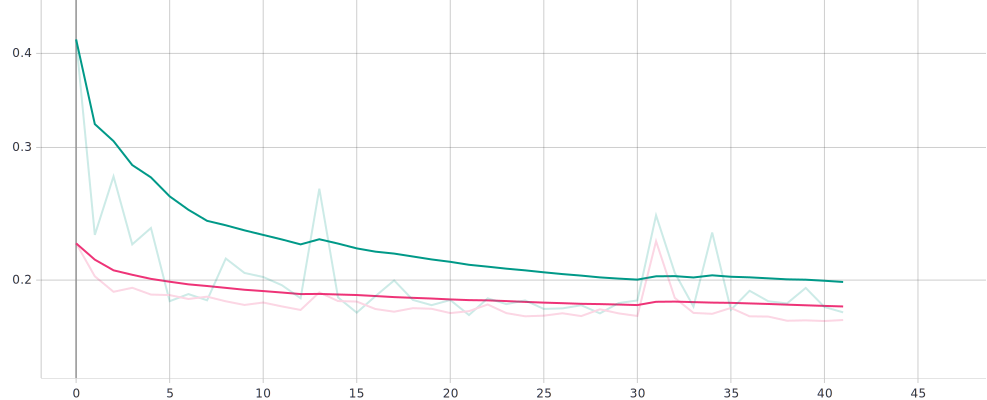

In [21]:
from IPython.display import SVG, display
def show_svg():
    display(SVG('epoch_loss.svg'))

show_svg()

Green line is test loss, deep pink is training loss. Y-axis is loss, X-axis is epoch number.

In [20]:
model = keras.models.load_model('my_final_project_model.h5')
X_test_prep = full_pipeline.fit_transform(X_test)

model.evaluate(X_test_prep, y_test)

65/65 [==============================] - 0s 1ms/step - loss: 0.1797 - accuracy: 0.9229


[0.17972886562347412, 0.9228904247283936]

The model's accuracy on the test set is **92.29%**. I actually used a proper training-validation-test set split to find the optimal hyperparameters for the model. Later when I found the hyperparameters according to the validation set I included the validation set also into the training data to improve the model's accuracy even more by letting it train on more data.

## 5) Making predictions for the unknown customer ID's

In [22]:
# Drop the exclusive column:
df_submit = df_submit.drop('exclusive', axis = 1)

In [24]:
# Save the customer id's to a new numpy array:
customer_ids = df_submit.iloc[:,0].to_numpy()
customer_ids = customer_ids.reshape((customer_ids.shape[0], 1))

# Run the predictor variables through the data preparation pipeline:
X_predict = full_pipeline.fit_transform(df_submit.iloc[:,1:])

# Make predictions on the unknown customer id's:
y_predict = (model.predict(X_predict) > 0.5).astype('int8')

# Merge customer ids together with the predictions:
predictions = np.concatenate((customer_ids, y_predict), axis = 1)

In [26]:
# Save predictions into a text file:
np.savetxt('submission_predictions.txt', (predictions))